In [1]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

/Users/sakka/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
dataset_df = pd.DataFrame()

day_lst = ["20170416", "20170417", "20170420", "20170421", "20170422", "20181030", "20181031"]

for day in day_lst:
    for t_idx in range(9, 17):
        tmp_dataset_df = pd.read_csv("../../data/datasets/{0}/default/time_series_leveled_{1}.csv".format(day, t_idx))

        # check NaN count
        assert tmp_dataset_df.isnull().values.sum() == 0

        dataset_df = pd.concat([dataset_df, tmp_dataset_df]).reset_index(drop=True)

    # shuffle dataset
    dataset_df = dataset_df.sample(frac=1)
    dataset_df = dataset_df.fillna(0)
    
    # check NaN count
    assert dataset_df.isnull().values.sum() == 0
    
for i in range(5):
    dataset_df.loc[dataset_df["label"] == i+1, "label"] = i
    
dataset_df.head()

,Fri,Mon,Sat,Sun,Thurs,Tue,Wed,area_ratio,degree_mean,degree_mean_shift1,...,overall_dir_right,overall_dir_right_down,overall_dir_right_up,overall_dir_up,right,right_down,right_up,up,var,var_shift1
193753,0,0,0,0,0,0,1,0.005111,153.160000,-39.875714,...,1,0,0,0.0,0.400000,0.120000,0.400000,0.0,43.5439,1.8701
8143,1,0,0,0,0,0,0,0.052756,91.800000,-24.021429,...,1,0,0,0.0,0.500000,0.100000,0.100000,0.0,47.2328,2.9522
180959,0,0,0,0,0,0,1,0.005065,135.066667,41.227957,...,0,0,0,0.0,0.200000,0.033333,0.000000,0.0,18.6089,-3.9023
85315,0,1,0,0,0,0,0,0.079413,83.606061,-71.935606,...,0,1,0,0.0,0.272727,0.303030,0.000000,0.0,90.9583,-72.0357
154484,0,0,0,0,0,1,0,0.005610,163.500000,45.500000,...,1,0,0,0.0,0.346154,0.000000,0.269231,0.0,28.0751,1.2228


In [3]:
dataset_df.columns

Index(['Fri', 'Mon', 'Sat', 'Sun', 'Thurs', 'Tue', 'Wed', 'area_ratio',
       'degree_mean', 'degree_mean_shift1', 'degree_std', 'degree_std_shift1',
       'diver', 'down', 'feed', 'grid_0_0', 'grid_0_1', 'grid_0_2', 'grid_0_3',
       'grid_0_4', 'grid_0_5', 'grid_0_6', 'grid_0_7', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_9',
       'label', 'left', 'left_down', 'left_up', 'max', 'max_index_grid_0_0',
       'max_index_grid_0_1', 'max_index_grid_0_2', 'max_index_grid_0_3',
       'max_index_grid_0_4', 'max_index_grid_0_5', 'max_index_grid_0_6',
       'max_index_grid_0_7', 'max_shift1', 'mean', 'mean_shift1',
       'overall_dir_down', 'overall_dir_left', 'overall_dir_left_down',
       'overall_dir_left_up', 'overall_dir_right', 'overall_dir_right_down',
       'overall_dir_right_up', 'overall_dir_up', 'right', 'right_down',
       'right_up', 'up', 'var', 'var_shift1'],
      dtype='object')

In [4]:
# check data balance, and convert numpy
y_train = dataset_df["label"].values
print("***************** Train *****************")
print("Level 1: {0} ({1} %)".format(np.sum(y_train == 0), np.sum(y_train == 0)/len(y_train)))
print("Level 2: {0} ({1} %)".format(np.sum(y_train == 1), np.sum(y_train == 1)/len(y_train)))
print("Level 3: {0} ({1} %)".format(np.sum(y_train == 2), np.sum(y_train == 2)/len(y_train)))
print("Level 4: {0} ({1} %)".format(np.sum(y_train == 3), np.sum(y_train == 3)/len(y_train)))
print("Level 5: {0} ({1} %)".format(np.sum(y_train == 4), np.sum(y_train == 4)/len(y_train)))

#dataset_df = dataset_df.drop(["label", "max", "var"], axis=1)
dataset_df = dataset_df.drop(["label"], axis=1)
X_train = dataset_df.values

***************** Train *****************
Level 1: 94676 (0.47047481799885704 %)
Level 2: 32784 (0.16291400601287054 %)
Level 3: 63104 (0.3135836211394638 %)
Level 4: 10032 (0.049852162894128756 %)
Level 5: 639 (0.0031753919546798517 %)


In [5]:
test_df = pd.DataFrame(columns=dataset_df.columns)
thresh_lst = []

for t_idx in range(9, 17):
    tmp_test_df = pd.read_csv("../../data/datasets/20170418/default/time_series_leveled_{0}.csv".format(t_idx))
    thresh_df = pd.read_csv("../../data/statistics/20170418/{0}/acc_thresh.csv".format(t_idx))["acc_thresh"]
    thresh_df = thresh_df.iloc[[i for i in range(0, len(thresh_df), 30)]]
    thresh_lst.extend(list(thresh_df))
    
    # check NaN count
    assert tmp_test_df.isnull().values.sum() == 0

    test_df = pd.concat([test_df, tmp_test_df]).reset_index(drop=True)


test_df = test_df.fillna(0)

# check NaN count
assert test_df.isnull().values.sum() == 0

for i in range(5):
    test_df.loc[test_df["label"] == i+1, "label"] = i
    
# check data balance, and convert numpy
y_test = test_df["label"].values
print("***************** Test *****************")
print("Level 1: {0} ({1} %)".format(np.sum(y_test == 0), np.sum(y_test == 0)/len(y_test)))
print("Level 2: {0} ({1} %)".format(np.sum(y_test == 1), np.sum(y_test == 1)/len(y_test)))
print("Level 3: {0} ({1} %)".format(np.sum(y_test == 2), np.sum(y_test == 2)/len(y_test)))
print("Level 4: {0} ({1} %)".format(np.sum(y_test == 3), np.sum(y_test == 3)/len(y_test)))
print("Level 5: {0} ({1} %)".format(np.sum(y_test == 4), np.sum(y_test == 4)/len(y_test)))

#test_df = test_df.drop(["label", "max", "var"], axis=1)
test_df = test_df.drop("label", axis=1)
X_test = test_df.values

***************** Test *****************
Level 1: 14950 (0.5200361764296647 %)
Level 2: 3888 (0.13524419090023654 %)
Level 3: 8569 (0.2980729094197857 %)
Level 4: 1267 (0.04407263113955753 %)
Level 5: 74 (0.0025740921107555307 %)


In [6]:
np.unique(X_test)

array([-856.045 , -571.7661, -399.855 , ...,  647.83  ,  771.229 ,
       1140.74  ])

In [7]:
lgb_train = lgb.Dataset(X_train, y_train, feature_name=list(dataset_df.columns))
lgb_test  = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [10]:
prm_1 = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 5,
    'num_leaves' : 2**5-1,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'metric': 'multi_logloss',
    # added 
    'verbose': -1,
}
prm_2 = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 5,
    'num_leaves' : 2**6, # changed
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'metric': 'multi_logloss',
    # added 
    'max_depth': 5,
    'bagging_freq': 1,
    'min_data_in_leaf': 1,
    'min_sum_hessian_in_leaf': 1,
    'lambda_l2': 1,
    'verbose': -1,
}

gbm = lgb.train(prm_2,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_test,
                early_stopping_rounds=5)

[1]	valid_0's multi_logloss: 1.10046
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's multi_logloss: 1.08061
[3]	valid_0's multi_logloss: 1.06222
[4]	valid_0's multi_logloss: 1.04454
[5]	valid_0's multi_logloss: 1.02849
[6]	valid_0's multi_logloss: 1.01735
[7]	valid_0's multi_logloss: 1.00655
[8]	valid_0's multi_logloss: 0.997719
[9]	valid_0's multi_logloss: 0.988077
[10]	valid_0's multi_logloss: 0.977705
[11]	valid_0's multi_logloss: 0.969638
[12]	valid_0's multi_logloss: 0.964387
[13]	valid_0's multi_logloss: 0.95961
[14]	valid_0's multi_logloss: 0.953213
[15]	valid_0's multi_logloss: 0.948246
[16]	valid_0's multi_logloss: 0.944886
[17]	valid_0's multi_logloss: 0.939751
[18]	valid_0's multi_logloss: 0.935217
[19]	valid_0's multi_logloss: 0.930612
[20]	valid_0's multi_logloss: 0.928121
[21]	valid_0's multi_logloss: 0.923914
[22]	valid_0's multi_logloss: 0.921637
[23]	valid_0's multi_logloss: 0.919597
[24]	valid_0's multi_logloss: 0.917939
[25]	valid_0's multi

In [11]:
np.argmax(gbm.predict(X_test, num_iteration=gbm.best_iteration), axis=1)

array([2, 2, 2, ..., 0, 0, 0])

In [12]:
pred_train = np.argmax(gbm.predict(X_train, num_iteration=gbm.best_iteration), axis=1)
pred_test = np.argmax(gbm.predict(X_test, num_iteration=gbm.best_iteration), axis=1)

train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)

target_names = ["level 1", "level 2", "level 3", "level 4", "level 5"]

print("*********************************************")
print("Train Accuracy: {}".format(train_acc))
print("Confusion Matrix: \n{}".format(confusion_matrix(y_train, pred_train)))
print("Classification report: \n{}".format(classification_report(y_train, pred_train, target_names=target_names)))
print("*********************************************")

print("*********************************************")
print("Test Accuracy: {}".format(test_acc))
print("Confusion Matrix: \n{}".format(confusion_matrix(y_test, pred_test)))
print("Classification report: \n{}".format(classification_report(y_test, pred_test, target_names=target_names)))
print("*********************************************")

*********************************************
Train Accuracy: 0.6381394886575397
Confusion Matrix: 
[[75379    75 19205     0    17]
 [ 8438   554 23765     8    19]
 [11206    77 51790     5    26]
 [ 1887    18  8043    70    14]
 [   12     0     4     0   623]]
Classification report: 
             precision    recall  f1-score   support

    level 1       0.78      0.80      0.79     94676
    level 2       0.77      0.02      0.03     32784
    level 3       0.50      0.82      0.62     63104
    level 4       0.84      0.01      0.01     10032
    level 5       0.89      0.97      0.93       639

avg / total       0.69      0.64      0.57    201235

*********************************************
*********************************************
Test Accuracy: 0.6562543481285654
Confusion Matrix: 
[[11562     1  3362     6    19]
 [ 1020     0  2866     1     1]
 [ 1330     5  7223     4     7]
 [  175     0  1084     7     1]
 [    0     0     0     0    74]]
Classification report: 
 

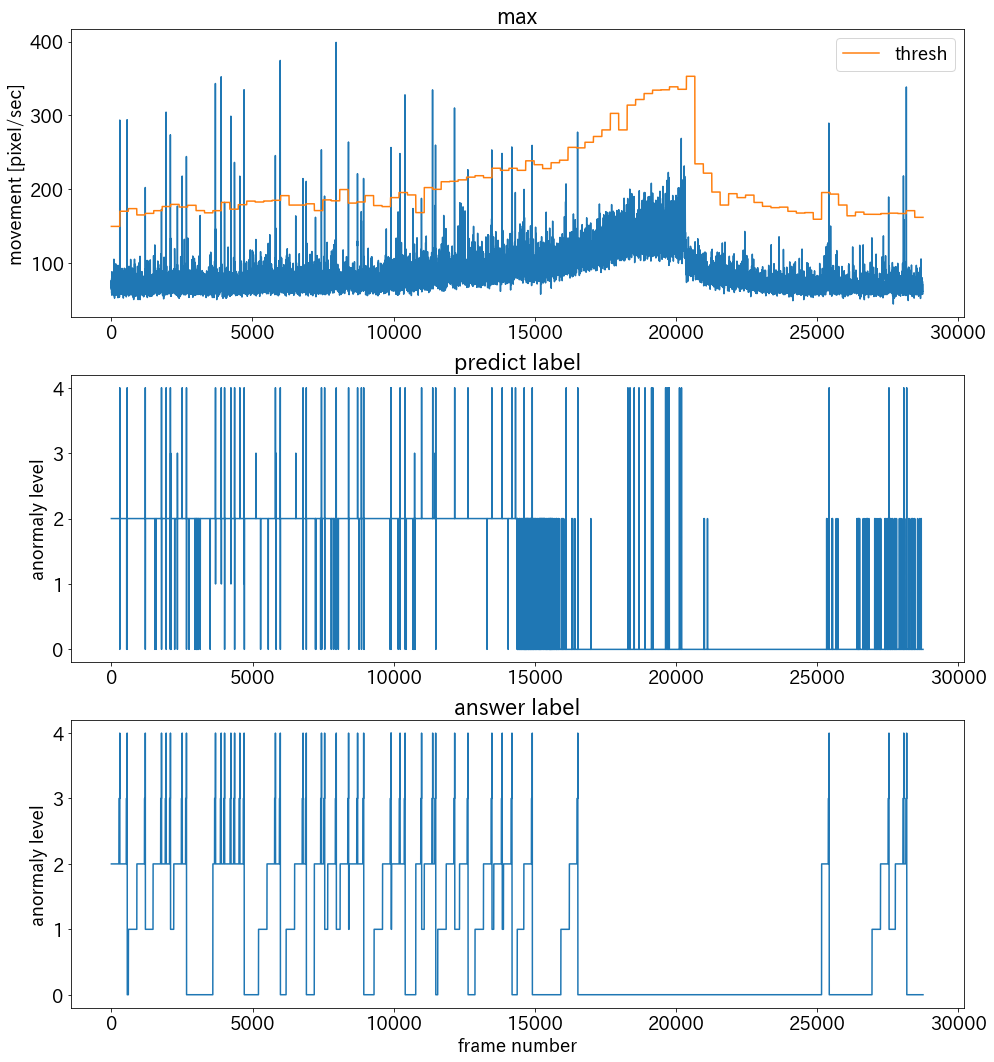

In [13]:
plt.figure(figsize=(16, 18))
plt.rcParams["font.size"] = 18

plt.subplot(3, 1, 1)
plt.plot(list(test_df["max"]))
plt.plot(thresh_lst, label="thresh")
plt.legend()
plt.title("max")
plt.ylabel("movement [pixel/sec]")

plt.subplot(3, 1, 2)
plt.plot(pred_test)
plt.title("predict label")
plt.ylabel("anormaly level")

plt.subplot(3, 1, 3)
plt.plot(y_test)
plt.title("answer label")
plt.ylabel("anormaly level")
plt.xlabel("frame number")

In [14]:
importances = gbm.feature_importance()
indices = np.argsort(importances)[::-1]
cols = dataset_df.columns

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("{0}. {1} ({2})".format(f + 1, cols[indices[f]], importances[indices[f]]))

Feature ranking:
1. area_ratio (916)
2. Wed (304)
3. Tue (292)
4. max (276)
5. mean (266)
6. var (256)
7. hour_14 (244)
8. grid_0_4 (197)
9. grid_0_1 (197)
10. hour_15 (172)
11. grid_0_2 (170)
12. Sat (166)
13. degree_std (160)
14. hour_13 (154)
15. Fri (154)
16. hour_11 (148)
17. hour_12 (142)
18. grid_0_6 (127)
19. hour_16 (123)
20. grid_0_5 (116)
21. right_down (113)
22. grid_0_3 (113)
23. grid_0_0 (110)
24. right_up (107)
25. Thurs (105)
26. max_shift1 (104)
27. right (104)
28. grid_0_7 (104)
29. left_up (97)
30. left (96)
31. mean_shift1 (95)
32. var_shift1 (92)
33. hour_10 (89)
34. Sun (88)
35. degree_mean (83)
36. hour_9 (78)
37. Mon (72)
38. degree_std_shift1 (67)
39. degree_mean_shift1 (66)
40. left_down (62)
41. diver (48)
42. feed (21)
43. up (21)
44. down (14)
45. max_index_grid_0_3 (6)
46. max_index_grid_0_2 (4)
47. max_index_grid_0_1 (4)
48. overall_dir_right (3)
49. overall_dir_left_up (2)
50. max_index_grid_0_4 (1)
51. overall_dir_left (1)
52. max_index_grid_0_0 (0)
53.

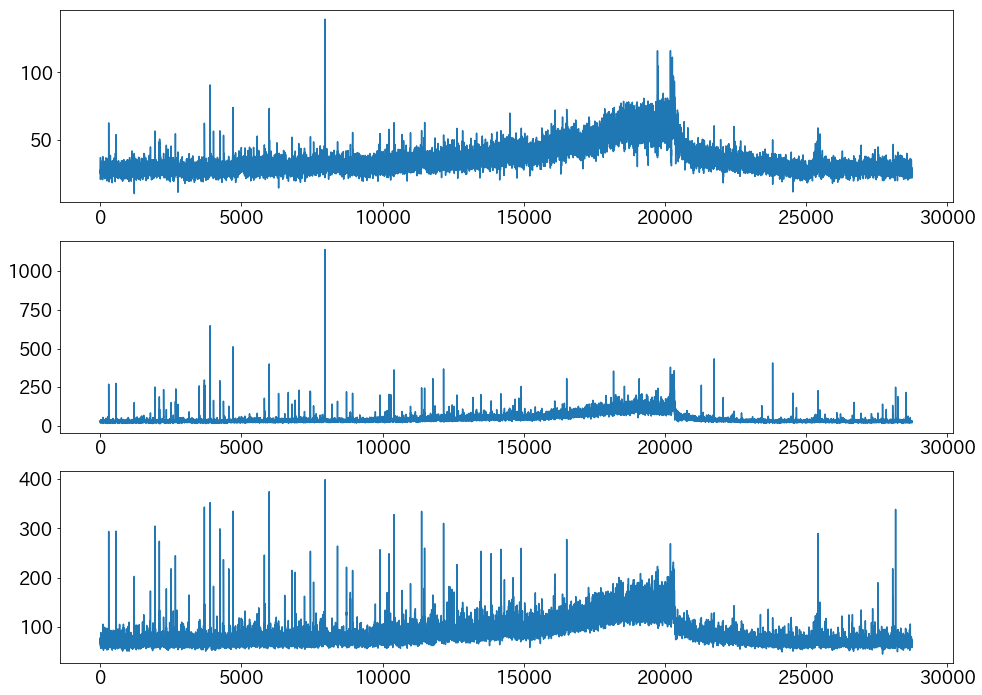

In [15]:
plt.figure(figsize=(16, 12))

plt.subplot(3, 1, 1)
plt.plot(list(test_df["mean"]))

plt.subplot(3, 1, 2)
plt.plot(list(test_df["var"]))

plt.subplot(3, 1, 3)
plt.plot(list(test_df["max"]))

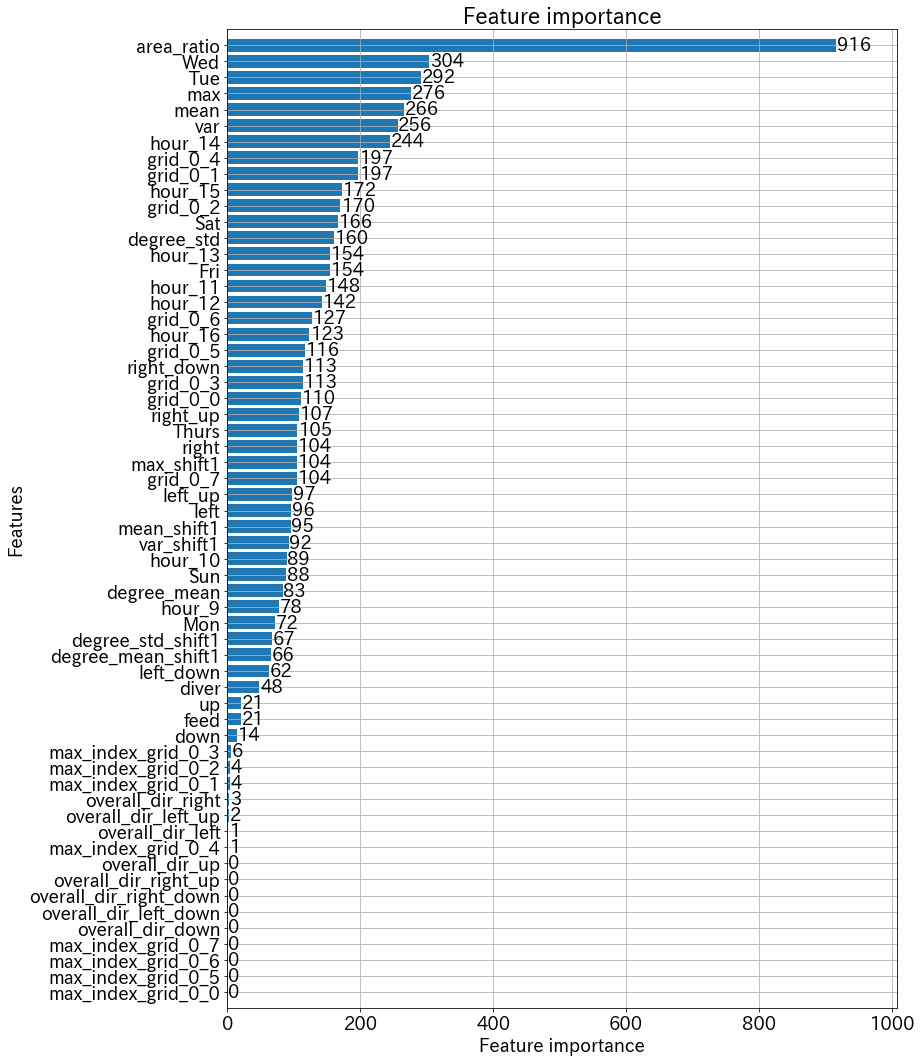

In [16]:
lgb.plot_importance(gbm, height=0.8, ignore_zero=False, figsize=(12, 18))
plt.show()
plt.savefig("./importance.png")

In [20]:
day_lst = ["20170416", "20170417", "20170418", "20170420", "20170421", "20170422", "20181030", "20181031"]
day2cnt = {}

for day in day_lst:
    dataset_df = pd.DataFrame()
    for t_idx in range(9, 17):
        tmp_dataset_df = pd.read_csv("../../data/datasets/{0}/default/time_series_{1}.csv".format(day, t_idx))

        # check NaN count
        assert tmp_dataset_df.isnull().values.sum() == 0

        dataset_df = pd.concat([dataset_df, tmp_dataset_df]).reset_index(drop=True)
    day2cnt[day] = np.sum(dataset_df["label"])

In [21]:
day2cnt

{'20170416': 62,
 '20170417': 78,
 '20170418': 74,
 '20170420': 65,
 '20170421': 38,
 '20170422': 84,
 '20181030': 153,
 '20181031': 159}